In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

file_path = '/content/drive/MyDrive/FYP/Autism_Screening_Data_Combined.csv'
df = pd.read_csv(file_path)

In [37]:
df = df[(df['Age'] <= 11) & (df['Age'] >= 4)]

In [11]:
x = df.drop(['Class', 'Family_ASD', 'Jauundice', 'Sex'], axis=1)
y = df['Class']


In [12]:
print(x.shape)
print(y.shape)


(1105, 11)
(1105,)


In [14]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)


In [15]:
print(le.classes_)
print(set(y))        # see all unique numeric classes
print(y[:10])        # see first few encoded labels


[0 1]
{np.int64(0), np.int64(1)}
[0 0 1 1 0 0 1 0 0 0]


In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)


In [17]:
print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (884, 11)
X_test shape: (221, 11)
y_train shape: (884,)
y_test shape: (221,)


In [18]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Input(shape=(x_train.shape[1],)),   # 👈 explicit input layer
    layers.Dense(64, activation='relu'),       # 1st hidden layer (ReLU)
    layers.Dense(32, activation='relu'),       # 2nd hidden layer (ReLU)
    layers.Dense(1, activation='sigmoid')      # Output layer (classifier)
])


In [19]:
from tensorflow.keras.callbacks import EarlyStopping

# Stop training when val_loss doesn't improve for 5 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,          # wait 5 epochs after no improvement
    restore_best_weights=True  # rollback to best model
)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True
)

In [21]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [22]:
history = model.fit(
    x_train, y_train,
    epochs=100,              # increase epochs safely
    batch_size=16,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop, checkpoint]   # 👈 add EarlyStopping
)


Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6324 - loss: 0.6414 - val_accuracy: 0.7514 - val_loss: 0.5506
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7695 - loss: 0.5058 - val_accuracy: 0.8136 - val_loss: 0.4381
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8000 - loss: 0.4249 - val_accuracy: 0.8418 - val_loss: 0.3756
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8370 - loss: 0.3611 - val_accuracy: 0.8588 - val_loss: 0.3129
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8944 - loss: 0.2897 - val_accuracy: 0.8983 - val_loss: 0.2728
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9128 - loss: 0.2538 - val_accuracy: 0.9096 - val_loss: 0.2422
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9199 - loss: 0.2147 - val_accuracy: 0.9153 - val_loss: 0.2213
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9370 - loss: 0.1802 - val_accuracy: 0.9266 - 

In [23]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9867 - loss: 0.0313 
Test Accuracy: 0.9774


In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_proba = model.predict(x_test)
y_pred_adjusted = (y_pred_proba > 0.4).astype("int32")



print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       115
           1       0.99      0.97      0.98       106

    accuracy                           0.98       221
   macro avg       0.98      0.98      0.98       221
weighted avg       0.98      0.98      0.98       221

[[114   1]
 [  3 103]]


In [31]:
# Save model
model.save('/content/drive/MyDrive/FYP/child_model.keras')


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


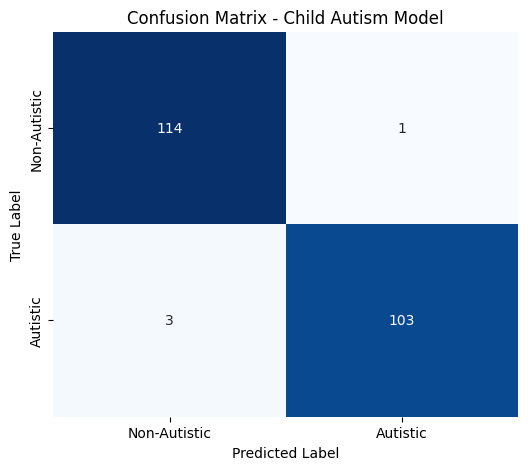

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions
y_pred = model.predict(x_test)
y_pred_classes = (y_pred > 0.4).astype("int32")  # Threshold at 0.5

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Autistic', 'Autistic'],
            yticklabels=['Non-Autistic', 'Autistic'])
plt.title('Confusion Matrix - Child Autism Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Save to Drive
plt.savefig('/content/drive/MyDrive/FYP/child_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

